In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from classy import Class
from scipy.integrate import quad, quad_explain, trapz
from scipy.stats import binned_statistic

%matplotlib inline

In [2]:
# instantiating class and assigning to cosmo object
cosmo = Class()

In [3]:
# free up memory before changing params
cosmo.struct_cleanup()
# changing cosmology
cosmo.empty()

# defining cosmological parameters

params = dict(output = 'mPk' 'tCl',
              z_pk = 0.0,
              A_s = 2.3e-9,
              n_s = 0.9624, 
              h = 0.6711,
              omega_b = 0.022068,
              omega_cdm = 0.12029)

# params = dict(output = 'mPk mTk',
#               z_pk = 0.0,
#               A_s = 2.3e-09,
#               n_s = 1, 
#               h = 0.7,
#               T_cmb = 2.726,
#               Omega_b = 0.05,
#               Omega_cdm = 0.25,
#               Omega_k = 0,
#               N_eff = 3.04,
#               YHe = 0.25,
#               z_reio = 10.
#              )


# setting params
cosmo.set(params)

True

In [4]:
# run code
cosmo.compute()

In [5]:
cosmo.tau_reio()

0.09285624327714383

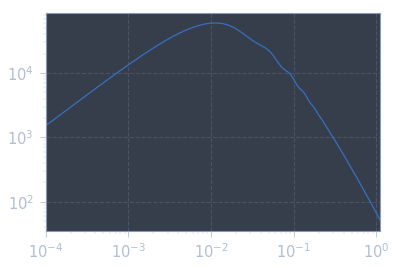

In [45]:
kmin, kmax = 1e-4, 1.118
npoints = 1000
ks = np.logspace(np.log10(kmin),np.log10(kmax),npoints)
pk_lin = [cosmo.pk_lin(k,cosmo.pars['z_pk']) for k in ks]
plt.loglog(ks,pk_lin)

plt.xlim(ks.min(),ks.max())
plt.show()

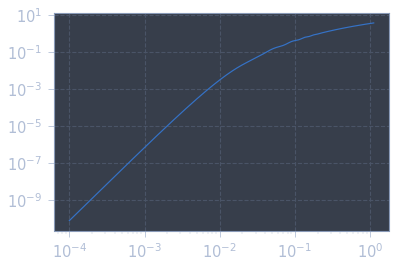

In [46]:
plt.loglog(ks,ks**3 * pk_lin /(2*np.pi**2))
plt.show()

Correlation function:
$$\xi(r) = \int \dfrac{dk}{2 \pi^2} k^2 P(k) \dfrac{\sin kr}{kr}$$

In [47]:
# integrand
def integrand(k, r, cosmo):
    """Integrand to get correlation function.
    Arguments:
     - k : float or array, scales to integrate over
     - r : float, comoving distance
     - cosmo : CLASS's computed instance."""
    z = cosmo.pars['z_pk']
    num = k*cosmo.pk(k,z)*np.sin(k*r)
    den = 2*(np.pi**2)*r
    return num/den

In [48]:
# correlation function
def xi(r,cosmo):
    int_r = lambda k: integrand(k,r,cosmo)
    return quad(int_r,0,1.118)[0]

xi = np.vectorize(xi)

In [49]:
def xi_binned(r, cosmo, bin_size=3):
    """r: array of positions to evalue correlation function over"""
    bins = np.arange(r.min(),r.max()+bin_size,bin_size)
    bin_means, bin_edges = binned_statistic(r,xi(r,cosmo),statistic='mean',bins=bins)[:2]
    bin_centers = bin_edges[1:] - bin_size/2
    return bin_centers, bin_means

/home/marcio/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/marcio/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


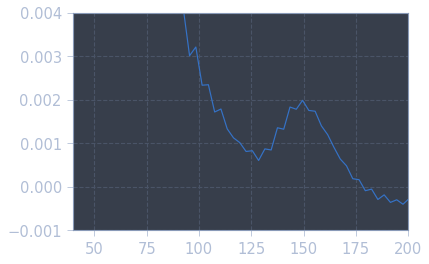

In [50]:
r = np.linspace(40,200,200)
#xi_r = xi(r,cosmo)
#plt.plot(r,xi_r)
#xi_bin, r_bin = xi_binned(r,xi_r)
plt.plot(*xi_binned(r,cosmo))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(-0.001,0.004)
plt.xlim(r.min(),r.max())
plt.show()

To keep in mind (from 1711.09063):
- They bin the correlation function with bin size $\Delta s = 3 Mpc/h$
- They range over which the fit is done is $(s_{max} - s_{min}) \leq 70 Mpc/h$, but If I understand correctly, fitting over larger ranges would only improve the result.
- They fit with 5th order polynomials.

### Comparing with pycamb

In [51]:
import camb

In [52]:
pars = camb.CAMBparams()

In [53]:
# params from class
params

{'A_s': 2.3e-09,
 'h': 0.6711,
 'n_s': 0.9624,
 'omega_b': 0.022068,
 'omega_cdm': 0.12029,
 'output': 'mPktCl',
 'z_pk': 0.0}

In [54]:
pars.set_cosmology(H0=cosmo.pars['h']*100,
                   ombh2=cosmo.pars['omega_b'], 
                   omch2=cosmo.pars['omega_cdm'],
                   mnu=0,
                  num_massive_neutrinos=0,
                  tau= cosmo.tau_reio())

pars.InitPower.set_params(ns=cosmo.pars['n_s'],
                          As=cosmo.pars['A_s'])

In [55]:
# power spectrum
pars.set_matter_power(redshifts=[cosmo.pars['z_pk']],
                     kmax=kmax)

In [56]:
camb_results = camb.get_results(pars)

In [57]:
kh_camb, z_camb, [pk_camb] = camb_results.get_matter_power_spectrum(
    minkh=kmin,maxkh=kmax, npoints=npoints)

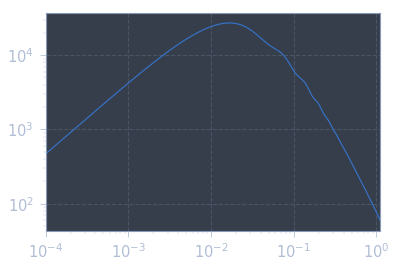

In [58]:
plt.loglog(kh_camb,pk_camb)
plt.xlim(xmin=kmin, xmax=kmax)
plt.show()

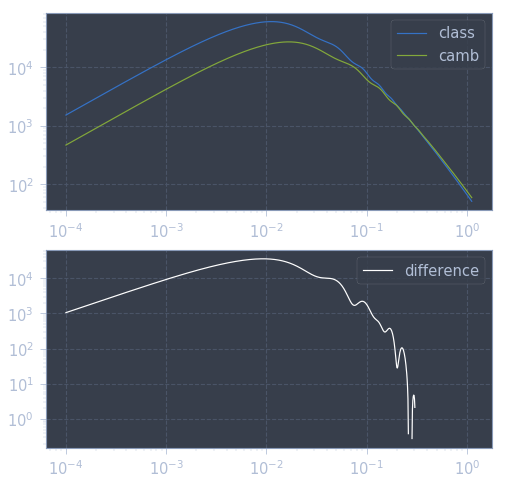

In [59]:
# comparing
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(8,8))

ax0.loglog(ks,pk_lin, label='class')
ax0.loglog(kh_camb,pk_camb, label='camb')

ax1.loglog(ks, pk_lin-pk_camb, 'w', label='difference')

ax0.legend()
ax1.legend()

plt.show()

In [21]:
# getting correlation function from camb

In [22]:
def xi_numeric(r,k,pk):
    num = k*pk*np.sin(k*r)
    den = 2*(np.pi**2)*r
    integral = trapz(num/den,k)
    return integral

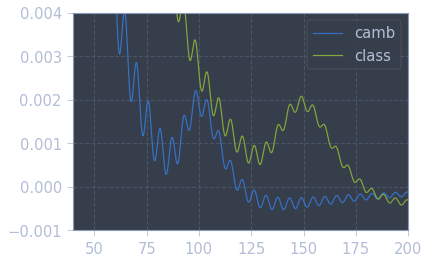

In [23]:
r = np.linspace(40,200,500)
xi_camb = [xi_numeric(i, kh_camb, pk_camb) for i in r]
xi_class = [xi_numeric(i, ks, pk_lin) for i in r]


plt.plot(r, xi_camb, label='camb')
plt.plot(r, xi_class, label='class')

plt.ylim(-0.001,0.004)
plt.xlim(r.min(),r.max())
plt.legend()
plt.show()

In [24]:
# does Cl^TT match?

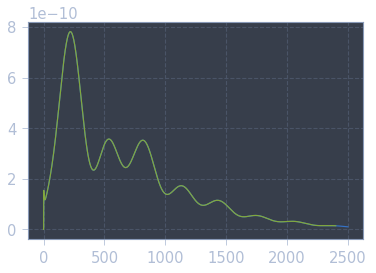

In [42]:
ell = cosmo.raw_cl()['ell']
plt.plot(ell*(ell+1)*cosmo.raw_cl()['tt']/(2*np.pi))
plt.plot(camb_results.get_cmb_power_spectra()['unlensed_scalar'][:,0])


plt.show()